# MedMNIST OOD Detection: Phase 1

__Identify out-of-modality images in a dataset of abnominal CTs (from three views: axial, saggital, coronal).__

In [1]:
import os
import json
import random
import time
import sys
sys.path.append("..")
from abc import ABC, abstractmethod

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
from torchvision.models import resnet18
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cdist
from medmnist_datasets import AbnominalCTDataset
from utils import SupConLoss
from networks.resnet_big import SupConResNet

with open("../cfg.json", "r") as f:
    cfg = json.load(f)

## Data

Source: https://medmnist.com/

Task: Distinguish axial views from sagittal/coronal views on abdominal CT scans from the Organ{A/C/S} Medical MNIST dataset. (The axial view was chosen as "OOD" since it was the most difficult for a logistic regression classifier to distinguish.)

Dataset Transforms:  ToTensor, Normalization (mu=0.5, std=0.5)

Training Transforms: RandomResized Crop, Rotations (+- 10 degrees), ToTensor, Normalization (mu=0.5, std=0.5)

In [2]:
# Baseline tr
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

positive_dataset="organamnist"

"""training dataset"""
train_set = AbnominalCTDataset(data_dir=cfg["data_dir"], label_mode="cheap-supervised",
                       positive_dataset=positive_dataset, tfms=data_transform,
                       split="train")

"""val dataset"""
val_set = AbnominalCTDataset(data_dir=cfg["data_dir"], label_mode="cheap-supervised",
                       positive_dataset=positive_dataset, tfms=data_transform,
                       split="val")
"""testing dataset"""
test_set = AbnominalCTDataset(data_dir=cfg["data_dir"], label_mode="cheap-supervised",
                       positive_dataset=positive_dataset, tfms=data_transform,
                       split="test")

Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organamnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organcmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organsmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organamnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organcmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organsmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organamnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organcmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organsmnist.npz


In [3]:
"""Matrixify fxn"""
def matrixify(dset, label_mode="cheap-supervised"):
    if label_mode!="cheap-supervised":
        raise NotImplementedError("label mode not implemented: {}".format(label_mode))
    X = np.empty((len(dset), 28*28))
    y = np.empty((len(dset)))
    for i in tqdm(range(len(dset))):
        image, label = dset[i]
        X[i,:] = image.flatten()
        y[i] = int(label)
    y = y.astype(np.int)
    return X,y

In [6]:
def view_organized_grid(dset: Dataset, random_seed=2023):
    random.seed(random_seed)
    fig, ax = plt.subplots(5,5, figsize=(12,12))
    plt.tight_layout()
    # first two rows will be in dist
    for i in range(2):
        for j in range(5):
            r = random.randint(0, len(dset)-1)
            while dset[r][1] != 1:
                r = random.randint(0, len(dset)-1)
#             print(dset[r][0].squeeze().max(), dset[r][0].squeeze().min())
            ax[i][j].imshow(dset[r][0].squeeze(), cmap="gray")
    # last three rows are out of dist
    for i in range(2,5):
        for j in range(5):
            r = random.randint(0, len(dset)-1)
            while dset[r][1] != 0:
                r = random.randint(0, len(dset)-1)
            ax[i][j].imshow(dset[r][0].squeeze(), cmap="gray")
    # remove ticks
    for i in range(5):
        for j in range(5):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])

Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organamnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organcmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organsmnist.npz


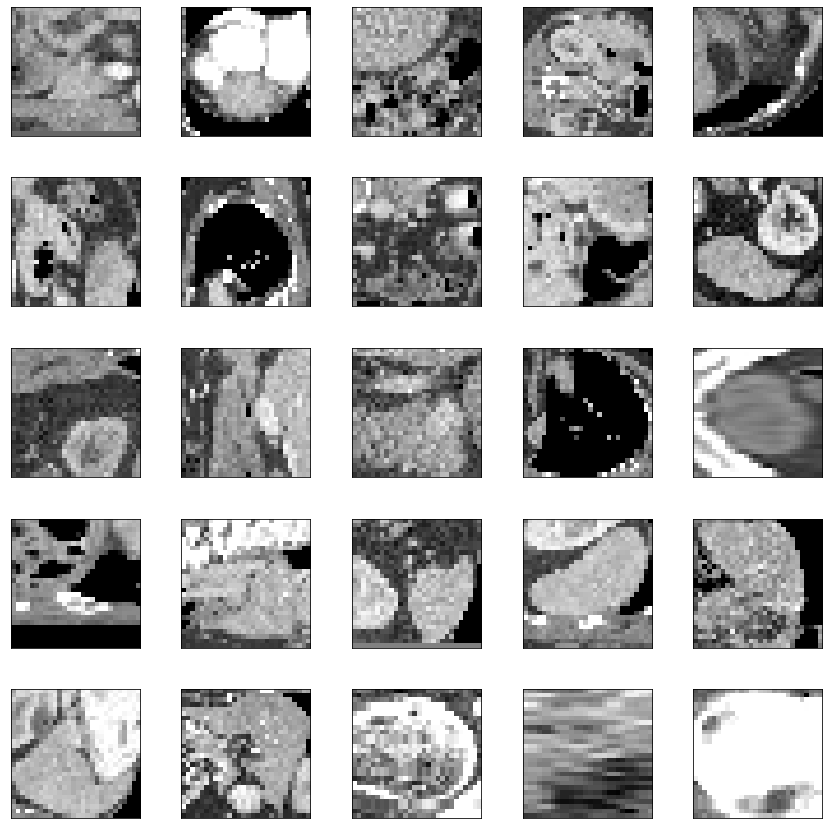

In [7]:
# No normalization
viewing_train_set = AbnominalCTDataset(data_dir=cfg["data_dir"], label_mode="cheap-supervised",
                       positive_dataset="organamnist", tfms=transforms.Compose([transforms.ToTensor()]),
                       split="train")
view_organized_grid(viewing_train_set)

## Classifiers

In [8]:
"""
Binary metrics fxns
"""
def get_binary_metrics(ytrue, yscore, ypred):
    # compute accuracy
    acc = np.sum(ytrue==ypred, dtype=np.float) / np.shape(ytrue)[0]
    # make one-hot encoded true vector
    y = np.zeros((ytrue.size, 2))
    y[np.arange(ytrue.size), ytrue] = 1
    # compute auroc
    auc = roc_auc_score(y, yscore)
    return acc, auc

In [9]:
"""Train an MLP on the features"""
def train_mlp(Xtrain, ytrain, Xtest, ytest, solver="adam", activation="relu", shuffle=True, random_state=2023):
    mlp_classifier = MLPClassifier(
        solver=solver,
        activation=activation,
        shuffle=shuffle,
        random_state=random_state,
        max_iter=500
    )
    
    mlp_classifier.fit(Xtrain,ytrain)
    ytrain_score = mlp_classifier.predict_proba(Xtrain)
    ytrain_pred = ytrain_score.argmax(axis=1)
    tr_acc, tr_auc = get_binary_metrics(ytrain, ytrain_score, ytrain_pred)

    ytest_score = mlp_classifier.predict_proba(Xtest)
    ytest_pred = ytest_score.argmax(axis=1)
    tt_acc, tt_auc = get_binary_metrics(ytest, ytest_score, ytest_pred)

    print("MLP Classifier: Training Accuracy {:.4f} | Training AUROC {:.4f}".format(tr_acc, tr_auc))
    print("MLP Classifier: Testing Accuracy {:.4f} | Testing AUROC {:.4f}".format(tt_acc, tt_auc))
    
    return mlp_classifier, {
        "training_acc": tr_acc,
        "training_auc": tr_auc,
        "testing_acc": tt_acc,
        "testing_auc": tt_auc,
    }

In [10]:
"""Logistic regression to classify examples (one vs. rest)"""
def train_lgr(Xtrain, ytrain, Xtest, ytest, solver="lbfgs", penalty="l2", C=1.0, max_iter=100, random_state=2023):
    lgr_classifier = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        max_iter=1000,
        random_state=random_state,
    )
    
    lgr_classifier.fit(Xtrain,ytrain)
    ytrain_score = lgr_classifier.predict_proba(Xtrain)
    ytrain_pred = ytrain_score.argmax(axis=1)
    tr_acc, tr_auc = get_binary_metrics(ytrain, ytrain_score, ytrain_pred)

    ytest_score = lgr_classifier.predict_proba(Xtest)
    ytest_pred = ytest_score.argmax(axis=1)
    tt_acc, tt_auc = get_binary_metrics(ytest, ytest_score, ytest_pred)

    print("Logistic Regression: Training Accuracy {:.4f} | Training AUROC {:.4f}".format(tr_acc, tr_auc))
    print("Logistic Regression: Testing Accuracy {:.4f} | Testing AUROC {:.4f}".format(tt_acc, tt_auc))
    
    return lgr_classifier, {
        "training_acc": tr_acc,
        "training_auc": tr_auc,
        "testing_acc": tt_acc,
        "testing_auc": tt_auc,
    }

In [11]:
"""Random forest to classify examples"""
def train_rf(Xtrain, ytrain, Xtest, ytest, n_estimators=20, random_state=2023):
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state
    )
    rf_model.fit(Xtrain,ytrain)
    ytrain_score = rf_model.predict_proba(Xtrain)
    ytrain_pred = ytrain_score.argmax(axis=1)
    tr_acc, tr_auc = get_binary_metrics(ytrain, ytrain_score, ytrain_pred)

    ytest_score = rf_model.predict_proba(Xtest)
    ytest_pred = ytest_score.argmax(axis=1)
    tt_acc, tt_auc = get_binary_metrics(ytest, ytest_score, ytest_pred)

    print("Random Forest: Training Accuracy {:.4f} | Training AUROC {:.4f}".format(tr_acc, tr_auc))
    print("Random Forest: Testing Accuracy {:.4f} | Testing AUROC {:.4f}".format(tt_acc, tt_auc))
    
    return rf_model, {
        "training_acc": tr_acc,
        "training_auc": tr_auc,
        "testing_acc": tt_acc,
        "testing_auc": tt_auc,
    }

## Training classifiers

In [12]:
"""
Matrixify the data
"""
Xtr, ytr = matrixify(train_set)
Xvl, yvl = matrixify(val_set)
Xtt, ytt = matrixify(test_set)

100%|██████████| 34875/34875 [00:04<00:00, 7428.57it/s]


In [15]:
train_lgr(Xtr, ytr, Xtt, ytt)

Logistic Regression: Training Accuracy 0.6885 | Training AUROC 0.7612
Logistic Regression: Testing Accuracy 0.6112 | Testing AUROC 0.6676


(LogisticRegression(max_iter=1000, random_state=2023),
 {'training_acc': 0.6884803563011004,
  'training_auc': 0.761201984765892,
  'testing_acc': 0.6112114695340501,
  'testing_auc': 0.6675969037665499})

LR model is ~ 60% accurate on testing set. Indicates our images are certainly not linearly separable!

In [16]:
train_mlp(Xtr, ytr, Xtt, ytt)

MLP Classifier: Training Accuracy 0.9992 | Training AUROC 0.9999
MLP Classifier: Testing Accuracy 0.7747 | Testing AUROC 0.8617


(MLPClassifier(max_iter=500, random_state=2023),
 {'training_acc': 0.9991547601631963,
  'training_auc': 0.9999137280456651,
  'testing_acc': 0.7746523297491039,
  'testing_auc': 0.8617320395883189})

MLP can achieve ~77% accuracy on test set. This is sensible: MLPs are nonlinear, so they would outperform a simple linear classifier.

In [17]:
np.savez(os.path.join(cfg["data_dir"], "../numpy_files/data_splits"),
        Xtr=Xtr, ytr=ytr,
        Xvl=Xvl, yvl=yvl,
        Xtt=Xtt, ytt=ytt,
        )

## Evaluation functions

In [19]:
"""Compute distances per test image against train distribution"""
def compute_distance(feature_train, feature_test):
    # ntest x ntrain
    time1 = time.time()
    matrix = cdist(feature_test, feature_train, metric="cosine")
    print("...Computed distances! {:.4f} secs".format(time.time()-time1))
    return matrix

In [20]:
"""Evaluate a feature space, binary labels"""
class EvaluateFeatureSpace(ABC):
    def __init__(self, model: nn.Module, device, y_train: np.ndarray,\
                 y_test: np.ndarray, subsample=True, n_sub=1000, random_seed=2023):
        random.seed(random_seed)
        
        self.device = device
        self.model = model
        self.model = self.model.to(self.device)
        self.feature_train = self.get_features(train_set)
        self.y_train = y_train
        self.feature_test = self.get_features(test_set)
        self.y_test = y_test
        
        # Save the original features
        self.original_attrs = {
            "y_train": self.y_train,
            "training_features": self.feature_train,
            "y_test": self.y_test,
            "testing_features": self.feature_test
        }
        
        self.subsample = subsample
        
        if self.subsample:
            idxs1 = random.sample(list(range(self.feature_train.shape[0])), k=n_sub)
            idxs2 = random.sample(list(range(self.feature_test.shape[0])), k=n_sub)
            self.feature_train = self.feature_train[idxs1,:]
            self.y_train = y_train[idxs1]
            self.feature_test = self.feature_test[idxs2,:]
            self.y_test = y_test[idxs2]
        
        # Make a mask to easily query where the positive images are
        self.y_train_mask = self.y_train==1
        self.y_test_mask = self.y_test==1
        
    @abstractmethod
    def get_features(self, dset: Dataset):
        pass
    
    def eval_internal(self, suptitle):
        dist_matrix = compute_distance(self.feature_train, self.feature_test)
        dists = [[[], []], [[], []]]
        # compute distributions
        m00 = dist_matrix[~(self.y_test_mask),:]
        m00 = m00[:,~(self.y_train_mask)]
        dists[0][0] = np.mean(m00, axis=1)

        m01 = dist_matrix[~(self.y_test_mask),:]
        m01 = m01[:,self.y_train_mask]
        dists[0][1] = np.mean(m01, axis=1)

        ood_dist = np.mean(dist_matrix[~(self.y_test_mask),:], axis=1)

        m10 = dist_matrix[self.y_test_mask,:]
        m10 = m10[:,~(self.y_train_mask)]
        dists[1][0] = np.mean(m10, axis=1)

        m11 = dist_matrix[self.y_test_mask,:]
        m11 = m11[:,self.y_train_mask]
        dists[1][1] = np.mean(m11, axis=1)

        id_dist = np.mean(dist_matrix[self.y_test_mask,:], axis=1)
        
        # plots
        fig, ax = plt.subplots(1,2, sharey=True)
        fig.tight_layout()

        # cosine distance ranges from 0-2
        # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
        ax[0].set_xlim([0,2])
        ax[1].set_xlim([0,2])
        ax[0].set_ylim([0,0.5])

        sns.histplot(dists[1][0], color="green", label="tr=0", kde=True, stat="probability", ax=ax[0])
        sns.histplot(dists[1][1], color="black", label="tr=1", kde=True, stat="probability", ax=ax[0])
        sns.histplot(id_dist, color="orange", label="total", kde=True, stat="probability", ax=ax[0])

        sns.histplot(dists[0][0], color="red", label="tr=0", kde=True, stat="probability", ax=ax[1])
        sns.histplot(dists[0][1], color="blue", label="tr=1", kde=True, stat="probability", ax=ax[1])
        sns.histplot(ood_dist, color="orange", label="total", kde=True, stat="probability", ax=ax[1])

        ax[0].set_title("ID Cosine Distance")
        ax[1].set_title("OOD Cosine Distance")
        ax[0].legend()
        ax[1].legend()

        plt.subplots_adjust(top=0.80)
        fig.suptitle(suptitle)

        plt.show()
    
    def eval_external(self, dset: Dataset, suptitle):
        ftr_tt = self.get_features(dset)
        dist_matrix = compute_distance(self.feature_train, ftr_tt)
        # compute distributions
        dists = [[], []]
        m00 = dist_matrix[:,~(self.y_train_mask)]
        dists[0] = np.mean(m00, axis=1)

        m01 = dist_matrix[:,self.y_train_mask]
        dists[1] = np.mean(m01, axis=1)

        ood_dist = np.mean(dist_matrix, axis=1)
        # plots
        plt.xlim([0,2])
        plt.ylim([0,0.5])
        # histplot
        sns.histplot(dists[0], color="red", label="tr=0", kde=True, stat="probability")
        sns.histplot(dists[1], color="blue", label="tr=1", kde=True, stat="probability")
        sns.histplot(ood_dist, color="orange", label="total", kde=True, stat="probability")

        plt.title("External Dataset Cosine Distance")
        plt.legend()

        plt.subplots_adjust(top=0.80)
        plt.suptitle(suptitle)

        plt.show()


## Learning features using a convolutional Autoencoder

No data augmentations

In [21]:
"""
Autoencoder
"""
class Encoder(nn.Module):
    def __init__(self, c_hid=16, latent_dim=100):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * 16 * c_hid, latent_dim),
        )
        
        pass
    def forward(self, x):
        return self.network(x)
    
class Decoder(nn.Module):
    def __init__(self, c_hid=16, latent_dim=100):
        super(Decoder, self).__init__()
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), nn.ReLU())
        self.network = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2
            ),
            nn.ReLU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(
                c_hid, 3, kernel_size=3, output_padding=1, padding=1, stride=2
            ),
            nn.Tanh(),
        )
    def forward(self, x):
        z = self.linear(x)
        z = z.reshape(z.shape[0], -1, 4, 4)
        return self.network(z)

class AutoEncoder(nn.Module):
    def __init__(self, c_hid=16, latent_dim=100):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(c_hid, latent_dim)
        self.decoder = Decoder(c_hid, latent_dim)
    def forward(self, x):
        return self.decoder(self.encoder(x))
    def get_features(self, x):
        return self.encoder(x)

In [22]:
"""Set gpus"""
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "3,4,5"
device = 'cpu'
ncpus = os.cpu_count()
dev_n = ncpus
if torch.cuda.is_available():
    device = 'cuda'
    dev_n = torch.cuda.device_count()
print('\nDevice: {} #: {} #cpus: {}\n'.format(device, dev_n, ncpus))


Device: cuda #: 3 #cpus: 96



In [23]:
"""Save model (source: https://github.com/HobbitLong/SupContrast/blob/master/util.py)"""
def save_model(model, optimizer, epch, hparams, fn):
    print("=> Saving!")
    state = {
        "model": model.state_dict(),
        "hparams": hparams,
        "optimizer": optimizer.state_dict(),
        "epoch": epch
    }
    torch.save(state, fn)
    del state

In [24]:
"""Load model"""
def load_autoencoder(pth):
    print("Loading! <= {}".format(os.path.basename(pth)))
    state = torch.load(pth)
    hparams = state["hparams"]
    model = AutoEncoder(c_hid=hparams["c_hid"], latent_dim=hparams["latent_dim"])
    model.load_state_dict(state["model"])
    model = model.to(hparams["device"])
    return model
    
"""Train model"""
def train_autoencoder(tr_set, vl_set, hparams):
    # loaders
    train_loader = DataLoader(tr_set, batch_size=hparams["bs"], shuffle=hparams["shuffle"])
    val_loader = DataLoader(vl_set, batch_size=hparams["bs"], shuffle=hparams["shuffle"])
    # model
    model = AutoEncoder(c_hid=hparams["c_hid"], latent_dim=hparams["latent_dim"])
    model = model.to(hparams["device"])
    save_fl = os.path.join(hparams["save_dir"], "autoencoder_{}_{}.pt".format(
        tr_set.get_positive_name(),
        time.time()
    ))
    # loss and optim
    loss_fxn = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams["lr"], weight_decay=hparams["wd"])
    # loop
    train_loss_history = []
    val_loss_history = []
    stopping_step = 0
    best_loss = np.inf
    for e in range(hparams["max_epochs"]):
        # training
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            # number of images
            n_images = images.shape[0]
            # make grayscale into 3 channel
            images = torch.cat([images, images, images], dim=1)
            images = images.to(hparams["device"])
            # model output
            outputs = model(images)
            # compute loss
            batch_loss = loss_fxn(images, outputs)
            # optimizer step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            # training loss
            train_loss += batch_loss.item() * n_images
        train_loss = train_loss / len(train_loader)
        train_loss_history.append(train_loss)
        # validation
        model.eval()
        val_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            with torch.no_grad():
                # number of images
                n_images = images.shape[0]
                # make grayscale into 3 channel
                images = torch.cat([images, images, images], dim=1)
                images = images.to(hparams["device"])
                # model output
                outputs = model(images)
                # compute loss
                batch_loss = loss_fxn(images, outputs)
                val_loss += batch_loss.item() * n_images
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)
        print("Epoch {} | Training Loss {:.4f} | Validation Loss {:.4f}".format(e, train_loss, val_loss))
        # early breaking
        if best_loss - val_loss > hparams["loss_threshold"]:
            stopping_step = 0
            best_loss = val_loss
            save_model(model, optimizer, e, hparams, save_fl)
        else:
            stopping_step += 1
        if stopping_step >= hparams["break_patience"]:
            print("...Early breaking!")
            break
    print("Model saved at: {}".format(save_fl))
    return model, train_loss_history, val_loss_history

In [25]:
"""Hyperparameters"""
autoenc_hparams = {
    "lr": 1e-2,
    "wd": 1e-3,
    "bs": 32,
    "shuffle": True,
    "max_epochs": 100,
    "loss_threshold": 1e-4,
    "break_patience": 5,
    "c_hid": 16,
    "latent_dim": 100,
    "device": device,
    "save_dir": "/cis/home/kvenka10/my_documents/contrastive-ood/saves/"
}

In [26]:
# model, tr_h, val_h = train_autoencoder(train_set, val_set, autoenc_hparams)
model = load_autoencoder(os.path.join(autoenc_hparams["save_dir"], "autoencoder_organamnist_1693262974.1492982.pt"))

Loading! <= autoencoder_organamnist_1693262974.1492982.pt


In [27]:
class EvaluateAutoEncoder(EvaluateFeatureSpace):
    def get_features(self, dset: Dataset, return_loss=False):
        self.model.eval()
        loss_fxn = torch.nn.MSELoss()
        features = []
        loss = 0.0
        ldr = DataLoader(dset, batch_size=32)
        for j, (images, labels) in enumerate(tqdm(ldr)):
            with torch.no_grad():
                images = torch.cat([images, images, images], dim=1)
                images = images.to(self.device)
                fts = self.model.get_features(images).detach().cpu().numpy()
                features.append(fts)
                outputs = self.model(images)
                batch_loss = loss_fxn(images, outputs)
                loss += batch_loss.item() * (images.shape[0])
        loss = loss / len(ldr)
        if return_loss:
            return np.vstack(features), loss
        return np.vstack(features)

In [28]:
evl = EvaluateAutoEncoder(model, autoenc_hparams["device"], ytr, ytt, subsample=True)

100%|██████████| 1090/1090 [00:06<00:00, 180.36it/s]


In [37]:
"""Extract features from train/test set"""
Ftr = evl.original_attrs["training_features"]
Ftt = evl.original_attrs["testing_features"]

In [38]:
np.savez(os.path.join(cfg["data_dir"], "../numpy_files/autoencoder_features"),
        autoencoder_Ftr=Ftr,
        autoencoder_Ftt=Ftt,
        )

...Computed distances! 0.0450 secs


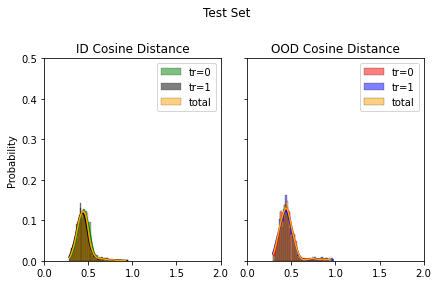

In [39]:
evl.eval_internal("Test Set")

## Train a traditional CNN classifier and extract features

Additional data augmentations (applied before ToTensor + Normalization): RandomResizedCrop, RandomRotation (+- 10 degrees)

In [40]:
"""CNN training with data augmentations"""
cnn_aug = transforms.Compose([
    transforms.RandomResizedCrop(size=28),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

"""training dataset"""
cnn_train_set = AbnominalCTDataset(data_dir=cfg["data_dir"], label_mode="cheap-supervised",
                       positive_dataset=positive_dataset, tfms=cnn_aug,
                       split="train")

"""val dataset"""
cnn_val_set = AbnominalCTDataset(data_dir=cfg["data_dir"], label_mode="cheap-supervised",
                       positive_dataset=positive_dataset, tfms=cnn_aug,
                       split="val")

Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organamnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organcmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organsmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organamnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organcmnist.npz
Using downloaded and verified file: /cis/home/kvenka10/my_documents/contrastive-ood/data/organsmnist.npz


In [45]:
"""Forward hook for ResNet"""
cnn_layers = {}
def get_inputs(name):
    def hook(model, inpt, output):
        cnn_layers[name] = inpt[0].detach()
    return hook

In [46]:
"""Load model"""
def load_cnn(pth):
    print("Loading! <= {}".format(os.path.basename(pth)))
    state = torch.load(pth)
    hparams = state["hparams"]
    model = resnet18(pretrained=hparams["pretrained"])
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=512, out_features=2),
        torch.nn.Sigmoid()
    )
    model.load_state_dict(state["model"])
    h = model.fc.register_forward_hook(get_inputs('fts'))
    model = model.to(hparams["device"]) 
    return model

"""Train CNN"""
def train_cnn(tr_set, vl_set, hparams):
    # loaders
    train_loader = DataLoader(tr_set, batch_size=hparams["bs"], shuffle=hparams["shuffle"])
    val_loader = DataLoader(vl_set, batch_size=hparams["bs"], shuffle=hparams["shuffle"])
    # model
    save_fl = os.path.join(hparams["save_dir"], "resnet18_{}_{}.pt".format(
        tr_set.get_positive_name(),
        time.time()
    ))
    # Init a model with forward hook for extracting features
    model = resnet18(pretrained=hparams["pretrained"])
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(in_features=512, out_features=2),
        torch.nn.Sigmoid()
    )
    h = model.fc.register_forward_hook(get_inputs('fts'))
    model = model.to(hparams["device"])   
    # loss and optim
    classification_loss_fxn = torch.nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams["lr"], weight_decay=hparams["wd"])
    # loop
    train_loss_history = []
    val_loss_history = []
    stopping_step = 0
    best_loss = np.inf
    for e in range(hparams["max_epochs"]):
        # training
        model.train()
        train_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            # number of images
            n_images = images.shape[0]
            # make grayscale into 3 channel
            images = torch.cat([images, images, images], dim=1)
            images = images.to(hparams["device"])
            # make labels into one-hot
            targets = torch.nn.functional.one_hot(labels, num_classes=2).float()
            targets = targets.to(hparams["device"])
            # model output
            outputs = model(images)
            # compute loss
            batch_loss = classification_loss_fxn(outputs, targets)
            # optimizer step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            # training loss
            train_loss += batch_loss.item() * n_images
        train_loss = train_loss / len(train_loader)
        train_loss_history.append(train_loss)
        # validation
        model.eval()
        val_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            with torch.no_grad():
                # number of images
                n_images = images.shape[0]
                # make grayscale into 3 channel
                images = torch.cat([images, images, images], dim=1)
                images = images.to(hparams["device"])
                # make labels into one-hot
                targets = torch.nn.functional.one_hot(labels, num_classes=2).float()
                targets = targets.to(hparams["device"])
                # model output
                outputs = model(images)
                # compute loss
                batch_loss = classification_loss_fxn(outputs, targets)
                val_loss += batch_loss.item() * n_images
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)
        print("Epoch {} | Training Loss {:.4f} | Validation Loss {:.4f}".format(e, train_loss, val_loss))
        # early breaking
        if best_loss - val_loss > hparams["loss_threshold"]:
            stopping_step = 0
            best_loss = val_loss
            save_model(model, optimizer, e, hparams, save_fl)
        else:
            stopping_step += 1
        if stopping_step >= hparams["break_patience"]:
            print("...Early breaking!")
            break
    print("Model saved at: {}".format(save_fl))
    return model, h, train_loss_history, val_loss_history

In [47]:
"""ResNet Hyperparameters"""
cnn_hparams = {
    "pretrained": True,
    "lr": 1e-2,
    "wd": 1e-3,
    "bs": 32,
    "shuffle": True,
    "max_epochs": 100,
    "loss_threshold": 1e-4,
    "break_patience": 5,
    "device": device,
    "save_dir": "/cis/home/kvenka10/my_documents/contrastive-ood/saves/"
}

In [48]:
"""Train a ResNet18 (w/ data augs) to classify"""
# cnn, h, tr_h, val_h = train_cnn(cnn_train_set, cnn_val_set, cnn_hparams)
cnn = load_cnn(os.path.join(cnn_hparams["save_dir"], "resnet18_organamnist_1693907738.0702972.pt"))

Loading! <= resnet18_organamnist_1693907738.0702972.pt


In [49]:
class EvaluateCNN(EvaluateFeatureSpace):
    def get_features(self, dset):
        self.model.eval()
        features = []
        classification_loss_fxn = torch.nn.BCELoss()
        loss = 0.0
        ldr = DataLoader(dset, batch_size=32)
        for j, (images, labels) in enumerate(tqdm(ldr)):
            with torch.no_grad():
                images = torch.cat([images, images, images], dim=1)
                images = images.to(self.device)
                outputs = self.model(images)
                features.append(cnn_layers['fts'].detach().cpu().numpy())
        return np.vstack(features)

In [50]:
evl = EvaluateCNN(cnn, autoenc_hparams["device"], ytr, ytt, subsample=True)

100%|██████████| 1090/1090 [00:08<00:00, 127.03it/s]


In [51]:
"""Extract features from train/test set"""
cnn_Ftr = evl.original_attrs["training_features"]
cnn_Ftt = evl.original_attrs["testing_features"]

In [52]:
np.savez(os.path.join(cfg["data_dir"], "../numpy_files/cnn_features"),
        cnn_Ftr=cnn_Ftr,
        cnn_Ftt=cnn_Ftt,
        )

...Computed distances! 0.2845 secs


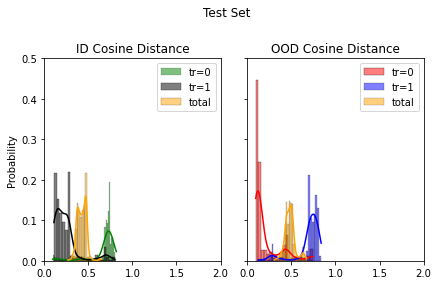

In [53]:
evl.eval_internal("Test Set")

## Get contrastive features

In [54]:
"""Load contrastive model"""
saves_dir = "/cis/home/kvenka10/my_documents/contrastive-ood/saves"
def load_ctr(pth, device):
    d = torch.load(pth)
    model = SupConResNet(name=d["opt"]["model"], head=d["opt"]["projection"])
    model.load_state_dict(d["model"])
    model = model.to(device)
    return model

In [55]:
class EvaluateCTR(EvaluateFeatureSpace):
    def get_features(self, dset):
        self.model.eval()
        features = []
        ldr = DataLoader(dset, batch_size=32)
        for j, (images, labels) in enumerate(tqdm(ldr)):
            with torch.no_grad():
                images = torch.cat([images, images, images], dim=1)
                images = images.to(self.device)
                outputs = self.model.encoder(images)
                norm_outputs = F.normalize(outputs)
                features.append(norm_outputs.detach().cpu().numpy())
        return np.vstack(features)

In [56]:
"""Load a trained supervised contrastive model (see tmp5)"""
sup_con_fl = "SupCon_resnet18_lr_0.05_decay_0.0001_bsz_256_temp_0.07_time_1693907762.1193209"
sup_con_model = load_ctr(os.path.join(saves_dir, sup_con_fl, "best.pth"), device)

In [58]:
supcon_evl = EvaluateCTR(sup_con_model, device, ytr, ytt, subsample=True)

100%|██████████| 1090/1090 [00:10<00:00, 101.83it/s]


In [59]:
sup_con_Ftr = supcon_evl.original_attrs["training_features"]
sup_con_Ftt = supcon_evl.original_attrs["testing_features"]

In [61]:
np.savez(os.path.join(cfg["data_dir"], "../numpy_files/ctr_features"),
        ctr_Ftr=sup_con_Ftr,
        ctr_Ftt=sup_con_Ftt,
        )

...Computed distances! 0.2760 secs


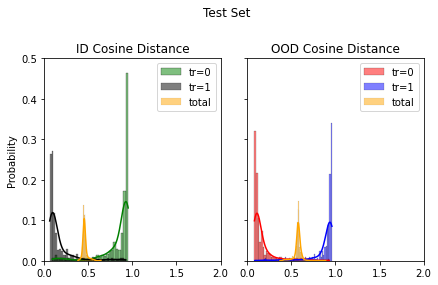

In [62]:
supcon_evl.eval_internal("Test Set")